In [183]:
%pylab inline
import os, csv
import operator

Populating the interactive namespace from numpy and matplotlib


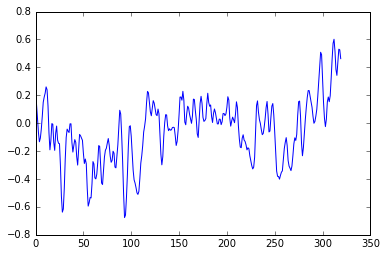

In [184]:
data_to_charge = 0 # 0 is for the music samples, 1 is for TIMIT
if data_to_charge not in (0, 1):
    raise ValueError("data_to_charge must be 0 (music) or 1 (speech)")
elif data_to_charge == 0:
    data_folder = "../sample/"
else:
    data_folder = "../timit"

files_names = (os.listdir(data_folder))
folder_size = len(files_names)
sample_lenght = 0

cr = csv.reader(open(data_folder + files_names[0], "r"))
for row in cr:
    sample_lenght += 1

data = np.zeros((folder_size, sample_lenght, 2))
    
for file_number, file in enumerate(files_names):
    cr = csv.reader(open(data_folder + file, "r"))
    for row_number, row in enumerate(cr):
        data[file_number][row_number] = [float(row[0]), float(row[1])]
        
plot(data[4][:,0])

In [185]:
class RNNNumpy:
    
    def __init__(self, out_dim, hidden_dim=10, bptt_truncate=10):
        # Assign instance variables
        self.out_dim = out_dim
        self.hidden_dim = hidden_dim
        self.bptt_truncate = bptt_truncate
        # Randomly initialize the network parameters
        self.V = np.random.normal(0, 0.1, (out_dim, hidden_dim))
        self.W = np.random.normal(0, 0.1, (hidden_dim, hidden_dim))
        self.bW = np.random.normal(0, 0.1, (hidden_dim))
        self.bV = np.random.normal(0, 0.1, (out_dim))


In [186]:
def forward_propagation(self, size, initialState):
    # The total number of time steps
    T = size
    # During forward propagation we save all hidden states in s because need them later.
    s = np.zeros((T , self.hidden_dim))
    #s[-1] = np.ones( self.hidden_dim)*initialState
    # The outputs at each time step. Again, we save them for later.
    o = np.zeros((T, self.out_dim))
    # For each time step...
    for t in np.arange(T):
        s[t] = np.tanh(self.W.dot(s[t-1]) + self.bW)
        o[t] = self.V.dot(s[t]) +self.bV
    return [o, s]

RNNNumpy.forward_propagation = forward_propagation

In [187]:
def predict(self, x):
    # Perform forward propagation and return index of the highest score
    o, s = self.forward_propagation(len(x), x[0])
    return o

RNNNumpy.predict = predict

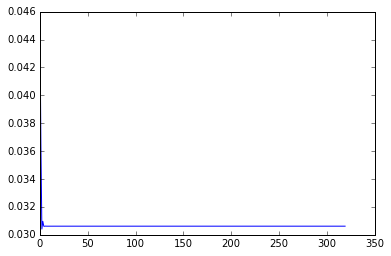

In [188]:
model = RNNNumpy(1, hidden_dim=10)
X_train = data[4][:,0]
#X_train = np.ones(320)*-0.75
o = model.predict(X_train)
plot(o)

In [189]:
def calculate_loss(self, x):
    o, s = self.forward_propagation(len(x), x[1])
    o=o.reshape(x.shape)
    return ((x-o)*(x-o)).sum()
RNNNumpy.calculate_loss=calculate_loss

In [190]:
loss = model.calculate_loss( X_train)
loss

19.040469298429198

In [191]:
def bptt(self, y):
    T = len(y)
    # Perform forward propagation
    o, s = self.forward_propagation(len(y), y[0])
    # We accumulate the gradients in these variables
    dLdV = np.zeros(self.V.shape)
    dLdW = np.zeros(self.W.shape)
    dLdbW = np.zeros(self.bW.shape)
    dLdbV = np.zeros(self.bV.shape)
    delta_o = (y.reshape((T,1)) - o)
    #delta_o[np.arange(len(x)), x] -= 1.
    # For each output backwards...
    for t in np.arange(T)[::-1]:
        dLdV += delta_o[t] * s[t]
        dLdbV += delta_o[t]
        # Initial delta calculation
        delta_t = self.V.T.dot(delta_o[t])
        for bptt_step in np.arange(max(0, t-self.bptt_truncate), t+1)[::-1]:
            # print "Backpropagation step t=%d bptt step=%d " % (t, bptt_step)
            dLdW += np.outer(delta_t, s[bptt_step-1]) 
            dLdbW += delta_t
            # Update delta for next step
            delta_t = self.W.T.dot(delta_t) * (1 - s[bptt_step-1] ** 2)
    return [dLdV, dLdbV, dLdW, dLdbW]

RNNNumpy.bptt = bptt

In [90]:
def bptt2(self, y):
    T = len(y)
    # Perform forward propagation
    o, s = self.forward_propagation(len(y), y[0])
    # We accumulate the gradients in these variables
    dLdV = np.zeros(self.V.shape)
    dLdW = np.zeros(self.W.shape)
    delta_o = np.zeros(T)
    delta  = np.zeros((T,self.hidden_dim))
    # For each output backwards...
    delta_o[T-1] = (y[T-1]-o[T-1])
    delta[T-1] = (delta_o[T-1]*self.W).sum(1) *(1- np.tanh(s[T-1])**2)
    dLdV += delta_o[T-1]*s[T-1]
    #TODO opti ?
    dLdW += delta[T-1]*s[T-2]
    for t in np.arange(T-1)[::-1]:
        #dLdV += np.outer(delta_o[t], s[t].T)
        delta_o[t] = (y[t]-o[t])
        delta[t] = (self.W.dot(delta[t+1]))*(1- np.tanh(s[t])**2)
        dLdV += delta_o[t]*s[t]
        if(t>0):
            dLdW += delta[t]*s[t-1]
    return [dLdV, dLdW]

RNNNumpy.bptt = bptt2

In [198]:
# Performs one step of SGD.
def numpy_sdg_step(self, x, learning_rate, momentum):
    #Nesterov Accelerated Gradient
    W, dW, V, dV = self.W, self.bW, self.V, self.bV
    self.W= self.W + momentum*self.velocityW
    self.bW= self.bW + momentum*self.velocitybW
    self.V= self.V + momentum*self.velocityV
    self.bV= self.bV + momentum*self.velocitybV
    
    dLdV, dLdbV, dLdW, dLdbW= self.bptt(x)

    # Change parameters according to gradients and learning rate
    self.velocityV = momentum*self.velocityV + learning_rate * dLdV
    self.velocityW = momentum*self.velocityW + learning_rate * dLdW
    self.velocitybV = momentum*self.velocitybV + learning_rate * dLdbV
    self.velocitybW = momentum*self.velocitybW + learning_rate * dLdbW
    
    self.V = self.V + self.velocityV
    self.W =self.W + self.velocityW
    self.bV = self.bV + self.velocitybV
    self.bW = self.bW + self.velocitybW

RNNNumpy.sgd_step = numpy_sdg_step

In [199]:
# Outer SGD Loop
# - model: The RNN model instance
# - x: séquence to generate
# - learning_rate: Initial learning rate for SGD
# - nepoch: Number of times to iterate through the complete dataset
def train_with_sgd(model, x, learning_rate=0.0003, momentum=0.95, nepoch=100, convergeance=0.0000001):
    # We keep track of the losses so we can plot them later
    losses = []
    model.velocityV=0
    model.velocityW=0
    model.velocitybV=0
    model.velocitybW=0
    
    # One SGD step
    loss = model.calculate_loss(x)
    losses.append(loss)
    model.sgd_step(x, learning_rate, momentum)
    for epoch in range(nepoch):
        # One SGD step

        loss = model.calculate_loss(x)
        losses.append(loss)
        model.sgd_step(x, learning_rate, momentum)
        #if(losses[-2]-losses[-1]<convergeance ): break
        
    return losses
 

In [203]:
losses = train_with_sgd(model, X_train, nepoch=1000, learning_rate=0.001)

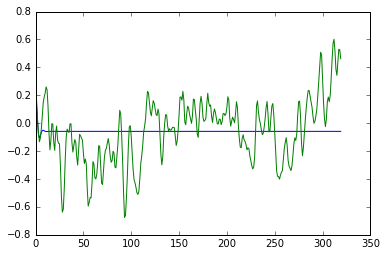

In [204]:

o = model.predict(X_train)
plot(o)
plot(X_train)

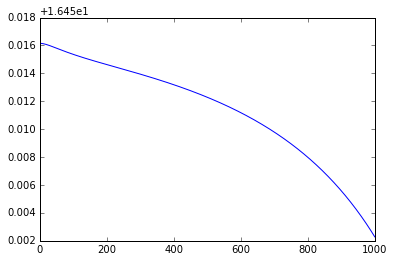

In [205]:
plot(losses)

In [52]:
model.W

array([[ nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan],
       [ nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan],
       [ nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan],
       [ nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan],
       [ nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan],
       [ nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan],
       [ nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan],
       [ nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan],
       [ nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan],
       [ nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan]])

In [173]:
operator

NameError: name 'operator' is not defined